# Assignment 1
Written by: Chengharv Pen (40279890)

# Task 1: Data Preparation and Exploration

<ul>
    <li>Load the provided dataset (customer_churn.csv) into Python.</li>
    <li>Perform exploratory data analysis (EDA):</li>
    <ul>
        <li>Display summary statistics.</li>
        <li>Identify missing values and handle them appropriately.</li>
        <li>Visualize data distributions using histograms and box plots.</li>
        <li>Check for correlations between variables.</li>
    </ul>
</ul>

In [1]:
import pandas as pd

dataset = pd.read_csv("./customer_churn.csv")

# Display summary statistics
print(f"{dataset.describe()}")

        CustomerID         Age  Subscription_Length_Months  Watch_Time_Hours  \
count  1000.000000  1000.00000                 1000.000000       1000.000000   
mean    500.500000    43.81900                   18.218000        100.794546   
std     288.819436    14.99103                   10.177822         56.477606   
min       1.000000    18.00000                    1.000000          5.036738   
25%     250.750000    31.00000                    9.000000         50.383080   
50%     500.500000    44.00000                   18.000000        100.234954   
75%     750.250000    56.00000                   27.000000        150.445885   
max    1000.000000    69.00000                   35.000000        199.944192   

       Number_of_Logins  Payment_Issues  Number_of_Complaints  \
count       1000.000000     1000.000000           1000.000000   
mean          50.387000        0.154000              4.546000   
std           28.224171        0.361129              2.919316   
min            1.00

In [2]:
# Identify missing values and handle them appropriately
print("\nChecking for null values...")
print(f"\n{dataset.isnull().sum()}")

print("\nDropping rows that have a null value...")
dataset = dataset.dropna()

print("\nVerifying that null rows have been dropped...")
print(f"\n{dataset.isnull().sum()}")


Checking for null values...

CustomerID                    0
Age                           0
Subscription_Length_Months    0
Watch_Time_Hours              0
Number_of_Logins              0
Preferred_Content_Type        0
Membership_Type               0
Payment_Method                0
Payment_Issues                0
Number_of_Complaints          0
Resolution_Time_Days          0
Churn                         0
dtype: int64

Dropping rows that have a null value...

Verifying that null rows have been dropped...

CustomerID                    0
Age                           0
Subscription_Length_Months    0
Watch_Time_Hours              0
Number_of_Logins              0
Preferred_Content_Type        0
Membership_Type               0
Payment_Method                0
Payment_Issues                0
Number_of_Complaints          0
Resolution_Time_Days          0
Churn                         0
dtype: int64


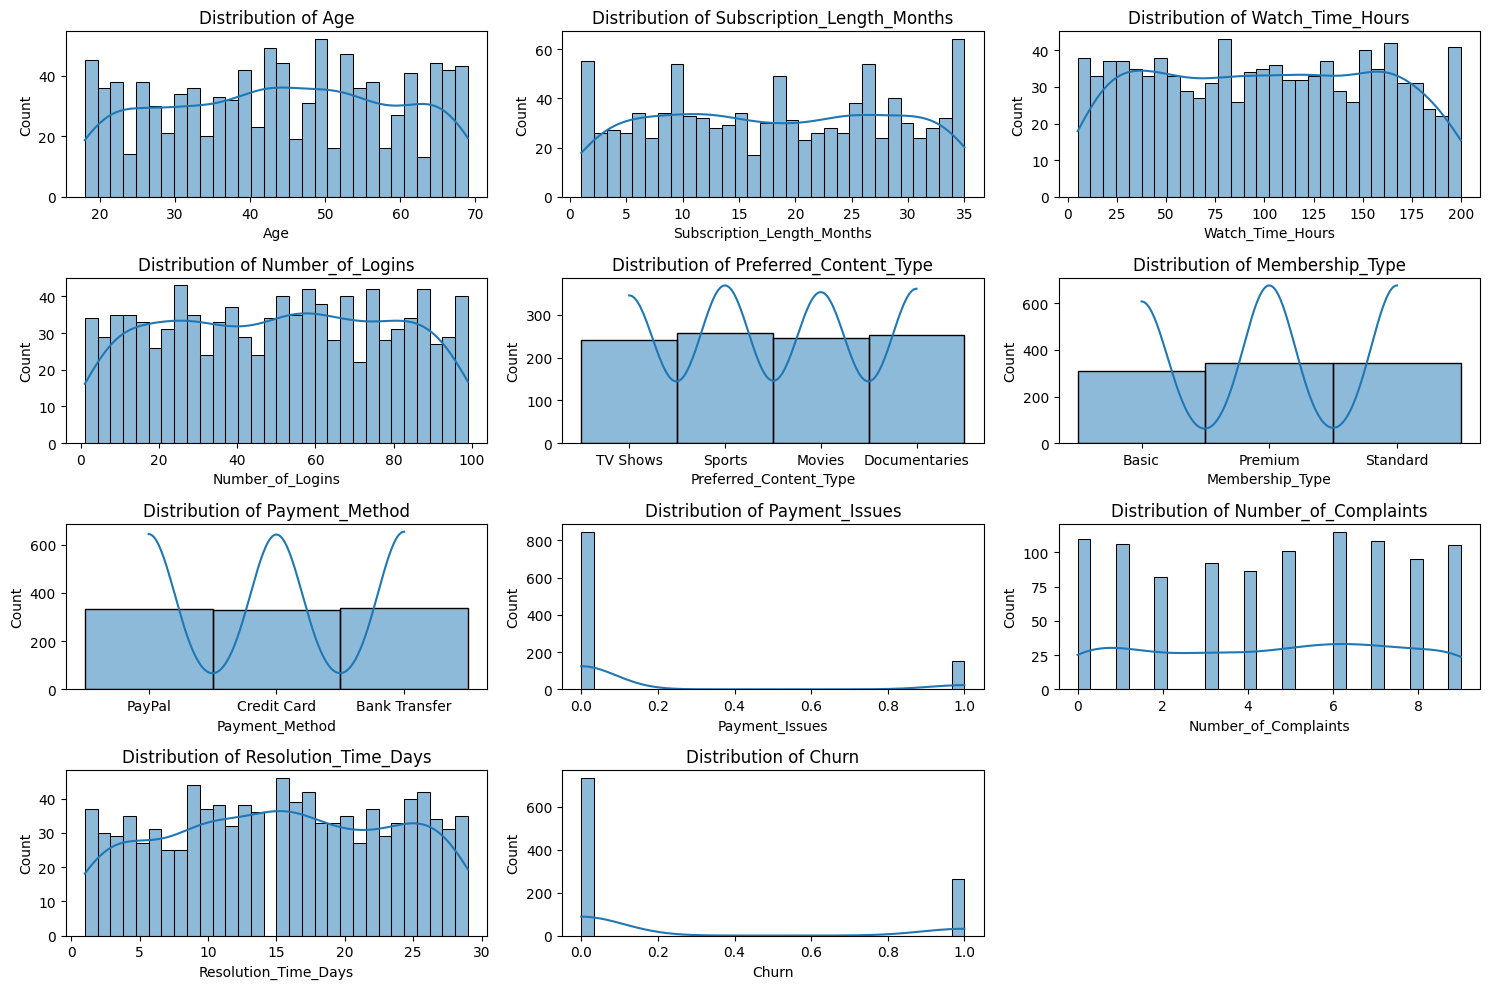

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualise data distributions using histograms
dataset_cols = dataset.columns
dataset_cols = dataset_cols.drop(['CustomerID'])

# Set up the figure for histograms
plt.figure(figsize=(15, 10))

for i, col in enumerate(dataset_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(dataset[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

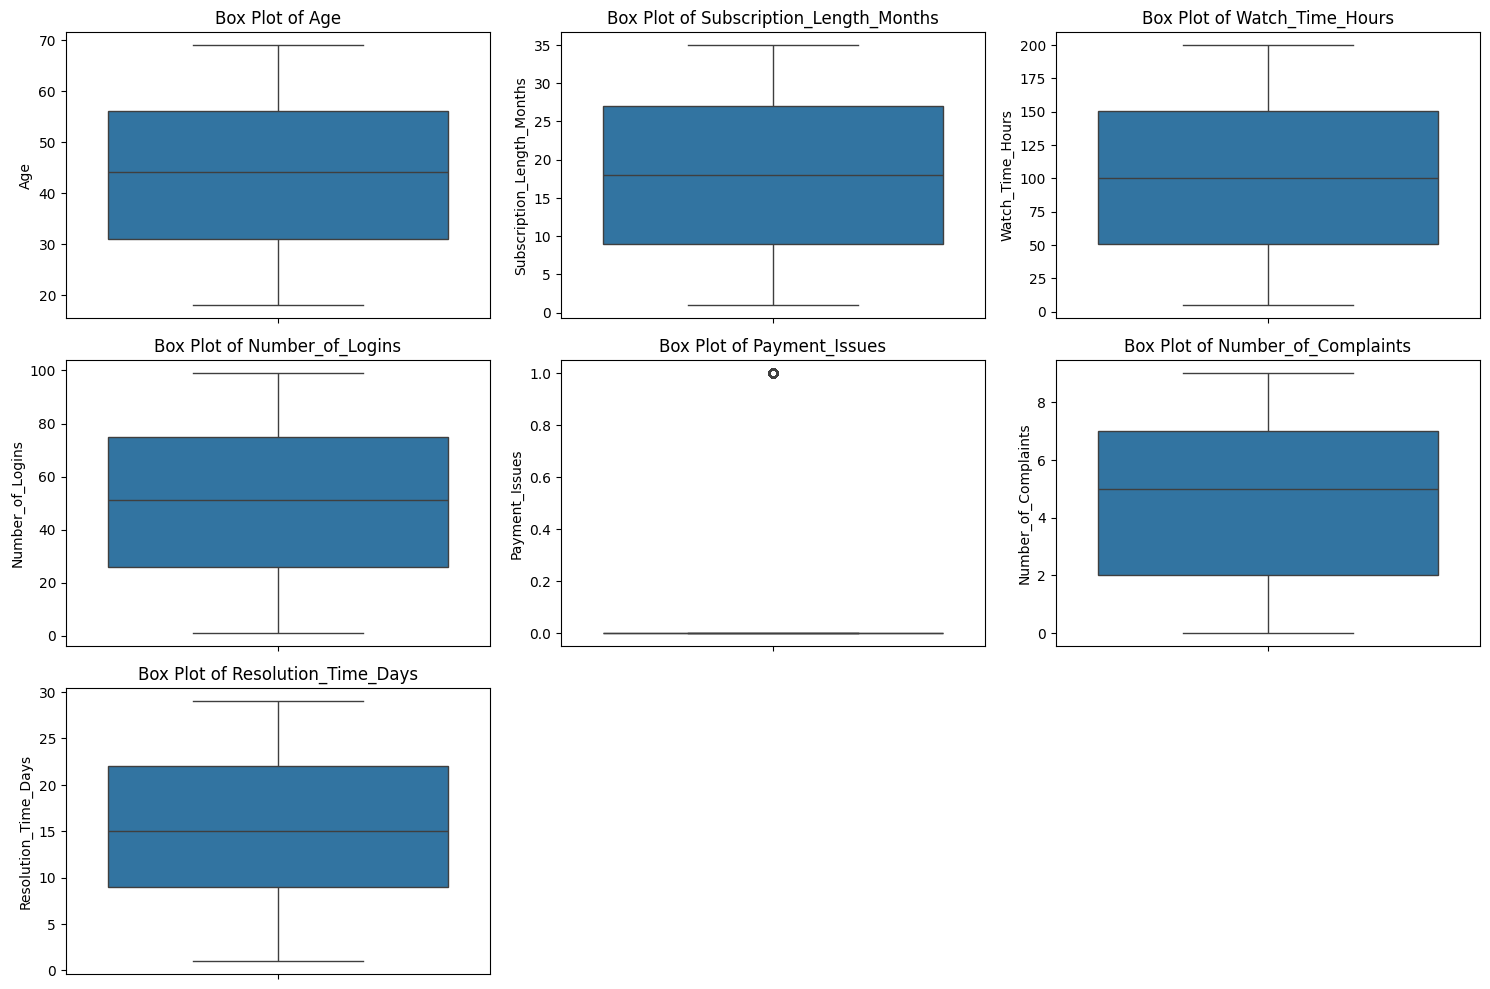

In [4]:
# Visualise data distributions using box plots

# Drop non-numerical values from dataset_cols
numerical_cols = dataset_cols.drop(['Preferred_Content_Type', 'Membership_Type', 'Payment_Method'])

# Payment_Issues and Churn should also be dropped, because they only have 0 OR 1 as values... 
# which wouldn't tell us much in a box plot
numerical_cols = numerical_cols.drop(['Churn'])

# Set up the figure for box plots
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=dataset[col])
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

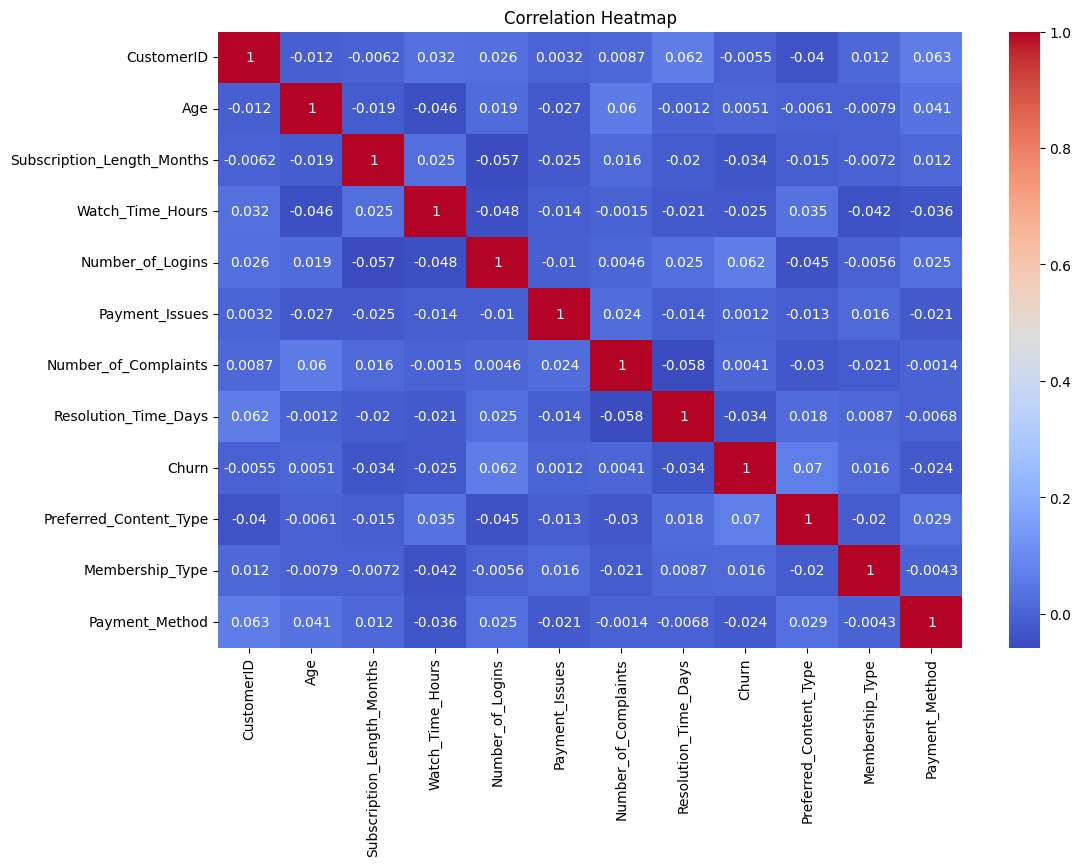

In [5]:
# Check for correlations between variables

# Convert categorical columns to category type
dataset['Preferred_Content_Type'] = dataset['Preferred_Content_Type'].astype('category')
dataset['Membership_Type'] = dataset['Membership_Type'].astype('category')
dataset['Payment_Method'] = dataset['Payment_Method'].astype('category')

# Convert categorical columns to codes
columns = ['Preferred_Content_Type', 'Membership_Type', 'Payment_Method']
dataset_conv = pd.DataFrame()

for col in columns:
    dataset_conv[col] = dataset[col].cat.codes  # Assigning directly to new DataFrame


correlation_dataset = dataset.drop(['Preferred_Content_Type', 'Membership_Type', 'Payment_Method'], axis=1)

for col in columns:
    correlation_dataset[col] = dataset_conv[col]


# Correlation heatmap
correlation = correlation_dataset.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Task 2: Building a Decision Tree Classifier

<ul>
    <li>Split the dataset into training and testing sets.</li>
    <li>Train a Decision Tree Classifier using scikit-learn.</li>
    <li>Use GridSearchCV to optimize hyperparameters (e.g., max depth, min samples split).</li>
    <li>Visualize the decision tree.</li>
    <li>Evaluate model performance using:</li>
    <ul>
        <li>Accuracy</li>
        <li>Precision</li>
        <li>Recall</li>
        <li>F1 Score</li>
        <li>Confusion Matrix</li>
    </ul>
</ul>

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

# One-hot encode nominal categorical columns
one_hot_encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_cols = one_hot_encoder.fit_transform(dataset[['Preferred_Content_Type', 'Payment_Method']])

encoded_df = pd.DataFrame(encoded_cols, columns=one_hot_encoder.get_feature_names_out(['Preferred_Content_Type', 'Payment_Method']))
dataset_encoded = pd.concat([dataset, encoded_df], axis=1).drop(columns=['Preferred_Content_Type', 'Payment_Method'])

# Encode ordinal categorical columns
ordinal_encoder = OrdinalEncoder(categories=[['Basic', 'Standard', 'Premium']])
dataset_encoded['Membership_Type'] = ordinal_encoder.fit_transform(dataset_encoded[['Membership_Type']])

# Features and target variable
X = dataset_encoded.drop(['CustomerID', 'Churn'], axis=1)
y = dataset_encoded['Churn']

# Train-test split using random state 42 and original dataset (80% Training, 20% Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resampling the training data, because our dataset is imbalanced
print("\nOriginal class distribution:", Counter(y_train))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_train))

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)


Original class distribution: Counter({0: 594, 1: 206})
Resampled class distribution: Counter({0: 594, 1: 594})

Training set size: (1188, 15)
Test set size: (200, 15)


### DISCLAIMER: 
<ul>
    <li>This code block took 14.4s to run on my computer. The specs are below:</li>
    <ul>
        <li>Operating System: Windows 11
        <li>Processor: AMD Ryzen 7 5825U with Radeon Graphics 2.00 GHz</li>
        <li>RAM: 16 GB</li>
        <li>Video Card: NVIDIA GeForce RTX 3050 Ti Laptop GPU</li>
    </ul>
</ul>

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Train a Decision Tree Classifier using scikit-learn

# Initialize the Decision Tree Classifier model
dt_model = DecisionTreeClassifier(random_state=42)

# Define hyperparameter search space
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10, 20],  
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"],
    "splitter": ["best"],
    "max_leaf_nodes": [None, 10, 20, 50],
    "class_weight": [None, "balanced"],
}

cv_values = [3, 5]
scoring_metric = make_scorer(f1_score, average="weighted")
best_dt_models = []

for cv in cv_values:
    grid_search = GridSearchCV(
        dt_model, 
        param_grid, 
        cv=cv, 
        scoring=scoring_metric, 
        n_jobs=-1, 
        verbose=1
    )

    # Train the model
    grid_search.fit(X_train, y_train)

    # Print best hyperparameters
    print("Best Parameters:", grid_search.best_params_)
    print(f"CV value: {cv}\n")

    # Get the best model for the current CV
    best_dt_model = grid_search.best_estimator_
    
    # Store best model for this CV
    best_dt_models.append(best_dt_model)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
CV value: 3

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
CV value: 5



In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate Decision Tree Classifier model's performance
index = 0

for best_dt_model in best_dt_models:
    print(f"DecisionTreeClassifier Model {index}, CV value {cv_values[index]}\n")
    index = index + 1
    
    # Predict on the test set
    y_pred = best_dt_model.predict(X_test)

    # Evaluation
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1Score = f1_score(y_test, y_pred)

    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1-score: {f1Score:.2f}")

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

DecisionTreeClassifier Model 0, CV value 3

Confusion Matrix:
[[121  20]
 [ 46  13]]
Accuracy: 0.67
Precision: 0.39
Recall: 0.22
f1-score: 0.28

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.79       141
           1       0.39      0.22      0.28        59

    accuracy                           0.67       200
   macro avg       0.56      0.54      0.53       200
weighted avg       0.63      0.67      0.64       200

DecisionTreeClassifier Model 1, CV value 5

Confusion Matrix:
[[105  36]
 [ 39  20]]
Accuracy: 0.62
Precision: 0.36
Recall: 0.34
f1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74       141
           1       0.36      0.34      0.35        59

    accuracy                           0.62       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.62      0.62      0.62       200



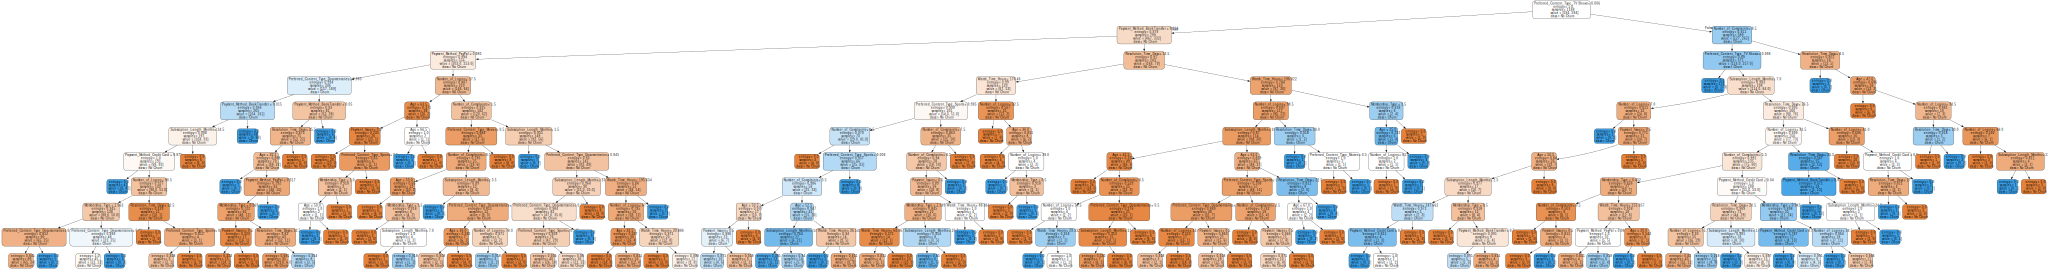

In [9]:
from sklearn.tree import export_graphviz
import graphviz

# Manually select the best Decision Tree Classifier Model, based on the previous code block's results
# From my testing with param_grid, I found that DecisionTreeClassifier Model 0 with CV value 3 has the highest Accuracy.
# So... Index 0. 
best_dt_model = best_dt_models[0]

# Export the tree to DOT format
dot_data = export_graphviz(
    best_dt_model,
    out_file=None, 
    feature_names=X_train.columns,  
    class_names=['No Churn', 'Churn'],  
    filled=True, 
    rounded=True,  
    special_characters=True
)

# Use Graphviz to render
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png")  # Saves as a file (decision_tree.png)
graph

In [10]:
# Get feature importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": best_dt_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance)

                                 Feature  Importance
11       Preferred_Content_Type_TV Shows    0.253312
12          Payment_Method_Bank Transfer    0.111411
13            Payment_Method_Credit Card    0.091026
0                                    Age    0.089340
3                       Number_of_Logins    0.077358
1             Subscription_Length_Months    0.069311
7                   Resolution_Time_Days    0.057122
6                   Number_of_Complaints    0.053094
8   Preferred_Content_Type_Documentaries    0.041344
14                 Payment_Method_PayPal    0.041325
2                       Watch_Time_Hours    0.040939
4                        Membership_Type    0.033905
10         Preferred_Content_Type_Sports    0.019183
5                         Payment_Issues    0.014953
9          Preferred_Content_Type_Movies    0.006379


# Task 3: Improving Performance with Random Forests

<ul>
    <li>Train a Random Forest Classifier.</li>
    <li>Compare its performance against the Decision Tree model.</li>
    <li>Analyze feature importance.</li>
    <li>Explain why the Random Forest model performed better (if applicable).</li>
</ul>

In [11]:
# NOTE: For some reason, training the Random Forest model with the non-resampled data yields better results.

# Train-test split using random state 42 and original dataset (80% Training, 20% Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (800, 15)
Test set size: (200, 15)


### DISCLAIMER:
<ul>
    <li>This code block took 16.9s to run on my computer. The specs are below:</li>
    <ul>
        <li>Operating System: Windows 11
        <li>Processor: AMD Ryzen 7 5825U with Radeon Graphics 2.00 GHz</li>
        <li>RAM: 16 GB</li>
        <li>Video Card: NVIDIA GeForce RTX 3050 Ti Laptop GPU</li>
    </ul>
</ul>

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Initialize the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter search space
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250, 300, 350, 400],
    "max_depth": [None, 10, 20, 30],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4],  
    "max_features": ["sqrt", "log2"],  
    "bootstrap": [True],  
    "criterion": ["gini", "entropy", "log_loss"], 
    "class_weight": [None, "balanced"],
}

cv_values = [3, 5]
scoring_metric = make_scorer(f1_score, average="weighted")
best_rf_models = []

for cv in cv_values:
    search = RandomizedSearchCV(
        rf_model, 
        param_distributions=param_grid, 
        n_iter=50,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42), 
        scoring=scoring_metric, 
        n_jobs=-1,
        verbose=1,
        random_state=42,
    )

    # Train the model
    search.fit(X_train, y_train)

    # Print best hyperparameters
    print("Best Parameters:", search.best_params_)
    print(f"CV value: {cv}\n")

    # Get the best model for the current CV
    best_rf_model = search.best_estimator_
    
    # Store best model for this CV
    best_rf_models.append(best_rf_model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
CV value: 3

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
CV value: 5



In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

index = 0

for best_rf_model in best_rf_models:
    print(f"RandomForestClassifier Model {index}, CV value {cv_values[index]}\n")
    index = index + 1
    
    # Predict on the test set
    y_pred = best_rf_model.predict(X_test)

    # Evaluation
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1Score = f1_score(y_test, y_pred)

    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1-score: {f1Score:.2f}")

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

RandomForestClassifier Model 0, CV value 3

Confusion Matrix:
[[134   7]
 [ 56   3]]
Accuracy: 0.69
Precision: 0.30
Recall: 0.05
f1-score: 0.09

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81       141
           1       0.30      0.05      0.09        59

    accuracy                           0.69       200
   macro avg       0.50      0.50      0.45       200
weighted avg       0.59      0.69      0.60       200

RandomForestClassifier Model 1, CV value 5

Confusion Matrix:
[[129  12]
 [ 52   7]]
Accuracy: 0.68
Precision: 0.37
Recall: 0.12
f1-score: 0.18

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.91      0.80       141
           1       0.37      0.12      0.18        59

    accuracy                           0.68       200
   macro avg       0.54      0.52      0.49       200
weighted avg       0.61      0.68      0.62       200



In [14]:
# From testing, RandomForestClassifier Model 1, CV value 5 has the best results
# So, index 1.
rf_model = best_rf_models[1]

# Get feature importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance)

                                 Feature  Importance
2                       Watch_Time_Hours    0.165065
3                       Number_of_Logins    0.154062
1             Subscription_Length_Months    0.138506
0                                    Age    0.136204
7                   Resolution_Time_Days    0.128385
6                   Number_of_Complaints    0.098512
4                        Membership_Type    0.041865
11       Preferred_Content_Type_TV Shows    0.020678
12          Payment_Method_Bank Transfer    0.018314
13            Payment_Method_Credit Card    0.018227
8   Preferred_Content_Type_Documentaries    0.018180
14                 Payment_Method_PayPal    0.017938
10         Preferred_Content_Type_Sports    0.016026
9          Preferred_Content_Type_Movies    0.015916
5                         Payment_Issues    0.012122
